In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import RidgeClassifierCV, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.optimizers import Adam

from tqdm.notebook import tqdm
from tqdm.keras import TqdmCallback

import features
import helpers
import plots

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [2]:
data_folder = 'data/csv/'

# get one mouse from each line
mice = [helpers.mice_breeds[line][0] for line in helpers.mice_breeds.keys()][:15] # get 15 mice from different lines
print(f"mice: {mice}")

data_files = [mouse + ".smo.csv" for mouse in mice]
data_files_train = data_files[:-1] # change [:1] to [:-1] to train on all instead of one
data_files_test = data_files[-1:]

print(f"Training on {data_files_train}")
print(f"Testing on {data_files_test}")

days = [0, 1, 2, 3]
window_sizes = [2, 5, 10, 20, 50, 100]
window_features = ["EEGv", "EMGv"]
spectral=True
rolloffs = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
test_size = 0.3
useRaw = False
dropBins = True
cat_matrix = True # True for neural net, any for random forest
standardize_df = False

seed = 13

mice: ['BL601', '1D203', 'BDF02', 'DBF01', '00501', '02901', '29T01', '03201', '04304', '04402', '04501', '04801', '04901', '05001', '05101']
Training on ['BL601.smo.csv', '1D203.smo.csv', 'BDF02.smo.csv', 'DBF01.smo.csv', '00501.smo.csv', '02901.smo.csv', '29T01.smo.csv', '03201.smo.csv', '04304.smo.csv', '04402.smo.csv', '04501.smo.csv', '04801.smo.csv', '04901.smo.csv', '05001.smo.csv']
Testing on ['05101.smo.csv']


In [3]:
# train and test on same mice
df_train = features.clean_data(
    data_folder=data_folder, 
    data_files=data_files_train,
    days=days, 
    window_sizes=window_sizes, 
    window_features=window_features,
    spectral=spectral,
    rolloffs=rolloffs,
    dropBins=dropBins, 
    useRaw=useRaw, 
    balance=True, 
    standardize_df=standardize_df
)

df_test = features.clean_data(
    data_folder=data_folder, 
    data_files=data_files_test,
    days=days, 
    window_sizes=window_sizes, 
    window_features=window_features,
    spectral=spectral,
    rolloffs=rolloffs,
    dropBins=dropBins, 
    useRaw=useRaw, 
    balance=False, 
    standardize_df=standardize_df
)

x_train, x_test, y_train, y_test, le = features.encode_scale_data(df_train=df_train, df_test=df_test, useRaw=useRaw, seed=seed, cat_matrix=cat_matrix)

c:\Users\matt989253\anaconda3\envs\temp2pip\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\matt989253\anaconda3\envs\temp2pip\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\matt989253\anaconda3\envs\temp2pip\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


# Neural Network

In [4]:
def baseline_model(input_dim, num_classes, lr=1e-4):
    model = Sequential()
    model.add(Dense(3, input_dim=input_dim, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=lr), metrics=['accuracy'])

    return model

model = baseline_model(x_train.shape[1], le.classes_.size)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 3)                 1326      
                                                                 
 dense_1 (Dense)             (None, 3)                 12        
                                                                 
Total params: 1,338
Trainable params: 1,338
Non-trainable params: 0
_________________________________________________________________


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

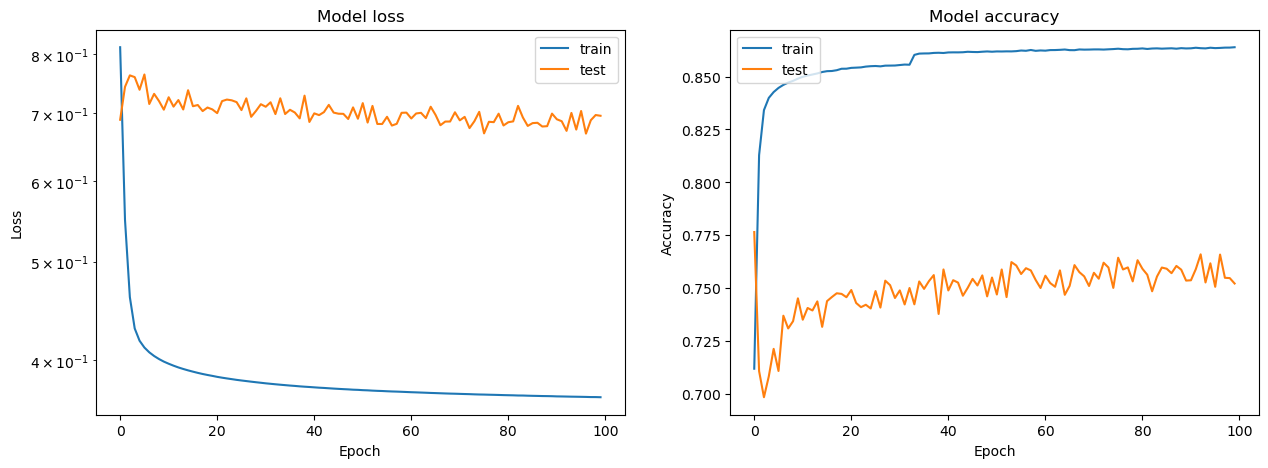

In [5]:
model = baseline_model(x_train.shape[1], le.classes_.size)
history = model.fit(x=x_train,
                    y=y_train,
                    validation_data=(x_test, y_test),
                    epochs=100,
                    batch_size=64,
                    verbose=0,
                    callbacks=[TqdmCallback(verbose=1)]
                )

plots.plot_history(history.history)

1518/1518 [==============================] - 1s 588us/step
[[15490  6466   673]
 [    3  2325     2]
 [  251  4634 18712]]
              precision    recall  f1-score   support

           n       0.98      0.68      0.81     22629
           r       0.17      1.00      0.30      2330
           w       0.97      0.79      0.87     23597

    accuracy                           0.75     48556
   macro avg       0.71      0.83      0.66     48556
weighted avg       0.94      0.75      0.81     48556



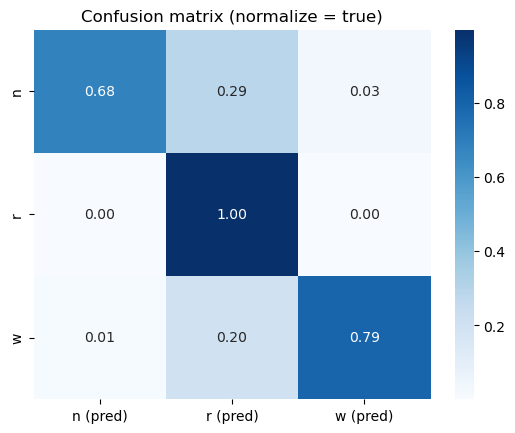

In [6]:
plots.plot_confusion(model=model, x_test=x_test, y_test=y_test, le=le, cat_matrix=True, normalize='true')

# K-Fold Cross Validation

In [7]:
#from sklearn.model_selection import KFold
#
#x, y, le = features.split_encode_scale_data_kfold(df, useRaw, seed, cat_matrix=True)
#model = baseline_model(x_train.shape[1], le.classes_.size)
#
#kfold = KFold(n_splits=5, shuffle=True)
#
## K-fold Cross Validation model evaluation
#fold_no = 1
#for train, test in kfold.split(x, y):
#  model = baseline_model(x_train.shape[1], le.classes_.size)
#  # Generate a print
#  print(f'Training for fold {fold_no} ...')
#
#  # Fit data to model
#  history = model.fit(x=x[train],
#                    y=y[train],
#                    epochs=300,
#                    batch_size=64,
#                    verbose=0,
#                )
#
#  # confusion matrix
#  cm = np.zeros((le.classes_.size, le.classes_.size))
#  cm = cm + plots.confusion(model=model, x_test=x[test], y_test=y[test], le=le, cat_matrix=True)
#  # Increase fold number
#  fold_no = fold_no + 1
#
#confusion = pd.DataFrame(cm, index=le.classes_, columns=le.classes_ + ' (pred)')
#sns.heatmap(confusion, annot=True, cmap="Blues", fmt='.2f')
#plt.title(f'Confusion matrix (normalize = true')
#plt.show()

# Random Forest

[[18161  4061   407]
 [   16  2314     0]
 [ 1022  1774 20801]]
              precision    recall  f1-score   support

           n       0.95      0.80      0.87     22629
           r       0.28      0.99      0.44      2330
           w       0.98      0.88      0.93     23597

    accuracy                           0.85     48556
   macro avg       0.74      0.89      0.75     48556
weighted avg       0.93      0.85      0.88     48556



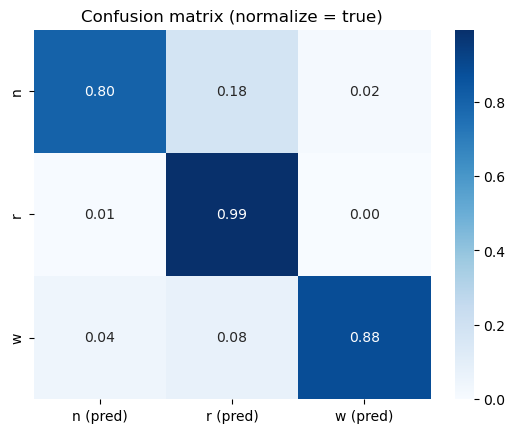

In [9]:
rfc = RandomForestClassifier(random_state=seed)
rfc.fit(x_train, y_train)
y_predict = rfc.predict(x_test)
plots.plot_confusion(model=rfc, x_test=x_test, y_test=y_test, le=le, cat_matrix=cat_matrix, normalize='true')